In [12]:
import pandas as pd

def upload_file():
    """Uploads a CSV file and returns a DataFrame."""
    from google.colab import files
    uploaded = files.upload()
    for file_name in uploaded.keys():
        print(f"File uploaded: {file_name}")
        return pd.read_csv(file_name)

# Run to upload your data
df = upload_file()


Saving Mall_Customers.csv to Mall_Customers (1).csv
File uploaded: Mall_Customers (1).csv


In [13]:
def data_overview(df):
    """Displays information and descriptive statistics about the DataFrame."""
    print("Data Info:")
    print(df.info())
    print("\nDescriptive Statistics:")
    print(df.describe())

# Run to check data overview
data_overview(df)


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None

Descriptive Statistics:
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.7500

In [15]:
from sklearn.preprocessing import StandardScaler

def preprocess_data(df):
    """Preprocess the data by dropping non-feature columns and standardizing."""
    features = df.drop(columns=['CustomerID'], errors='ignore')  # Handle potential errors
    features = pd.get_dummies(features, drop_first=True)

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    return scaled_features

# Run to preprocess data
scaled_features = preprocess_data(df)


In [17]:
from sklearn.decomposition import PCA

def optimal_pca(scaled_features, variance_threshold=0.90):
    """Applies PCA to reduce dimensions while retaining specified variance."""
    pca = PCA()
    pca.fit(scaled_features)
    cumulative_variance = pca.explained_variance_ratio_.cumsum()

    n_components = next(i for i, total_variance in enumerate(cumulative_variance) if total_variance >= variance_threshold) + 1
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(scaled_features)

    print(f"Selected {n_components} components to retain {variance_threshold*100}% of the variance.")

    return reduced_data

# Run to apply PCA
reduced_data = optimal_pca(scaled_features)


Selected 4 components to retain 90.0% of the variance.


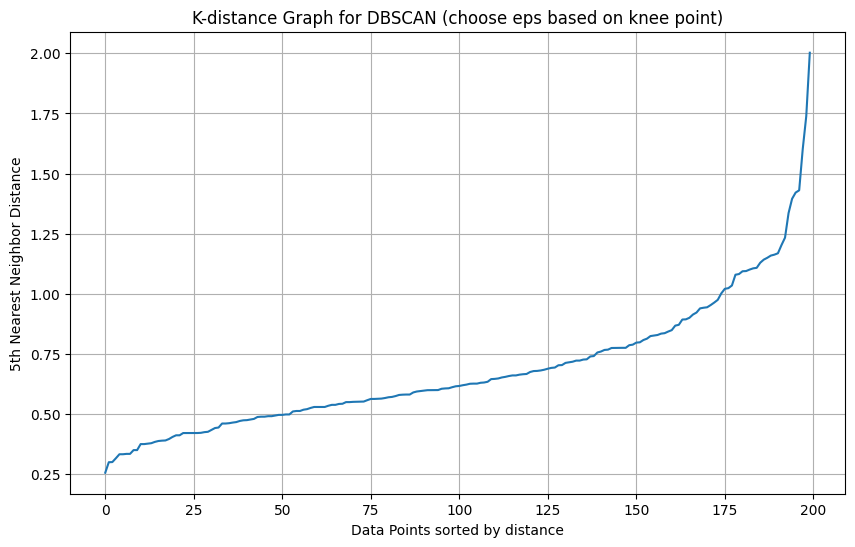

In [18]:
from sklearn.neighbors import NearestNeighbors

def find_optimal_eps(reduced_data):
    """Visualizes the K-distance graph to help determine optimal eps for DBSCAN."""
    neighbors = NearestNeighbors(n_neighbors=5)
    neighbors_fit = neighbors.fit(reduced_data)
    distances, indices = neighbors_fit.kneighbors(reduced_data)

    distances = np.sort(distances[:, 4], axis=0)
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.title('K-distance Graph for DBSCAN (choose eps based on knee point)')
    plt.xlabel('Data Points sorted by distance')
    plt.ylabel('5th Nearest Neighbor Distance')
    plt.grid()
    plt.show()

# Run to visualize K-distance graph
find_optimal_eps(reduced_data)


In [19]:
from sklearn.cluster import DBSCAN

def perform_dbscan(reduced_data, eps=0.5, min_samples=5):
    """Performs DBSCAN clustering and returns the assigned clusters."""
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(reduced_data)

    return clusters

# Run DBSCAN with chosen parameters
eps = 0.5  # Adjust as needed based on the K-distance graph
min_samples = 5
clusters = perform_dbscan(reduced_data, eps, min_samples)

# Add cluster labels to the original DataFrame
df['Cluster'] = clusters


In [20]:
def cluster_analysis(df):
    """Analyzes the clusters and returns a summary of mean values for numeric features."""
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    return df.groupby('Cluster')[numeric_cols].mean()

# Run to analyze clusters
cluster_summary = cluster_analysis(df)

def generate_feedback(cluster_summary, df):
    """Generates feedback on the clusters based on average metrics in the desired format."""
    feedback = {}
    for cluster, data in cluster_summary.iterrows():
        total_customers = df[df['Cluster'] == cluster].shape[0]
        feedback[cluster] = {
            "Average Age": round(data['Age'], 2),
            "Average Annual Income": round(data['Annual Income (k$)'], 2),
            "Average Spending Score": round(data['Spending Score (1-100)'], 2),
            "Total Customers": total_customers,
        }

    return feedback

# Generate and display feedback
feedback = generate_feedback(cluster_summary, df)
for cluster, insights in feedback.items():
    print(f"Cluster {cluster}:")
    for key, value in insights.items():
        print(f"  {key}: {value:.2f}" if isinstance(value, float) else f"  {key}: {value}")


Cluster -1:
  Average Age: 39.31
  Average Annual Income: 63.58
  Average Spending Score: 40.85
  Total Customers: 105
Cluster 0:
  Average Age: 24.00
  Average Annual Income: 20.40
  Average Spending Score: 75.00
  Total Customers: 5
Cluster 1:
  Average Age: 25.40
  Average Annual Income: 23.60
  Average Spending Score: 74.60
  Total Customers: 5
Cluster 2:
  Average Age: 49.72
  Average Annual Income: 53.39
  Average Spending Score: 50.33
  Total Customers: 18
Cluster 3:
  Average Age: 25.44
  Average Annual Income: 53.89
  Average Spending Score: 48.28
  Total Customers: 18
Cluster 4:
  Average Age: 57.40
  Average Annual Income: 52.07
  Average Spending Score: 48.87
  Total Customers: 15
Cluster 5:
  Average Age: 22.86
  Average Annual Income: 61.00
  Average Spending Score: 50.43
  Total Customers: 7
Cluster 6:
  Average Age: 66.50
  Average Annual Income: 62.75
  Average Spending Score: 50.50
  Total Customers: 4
Cluster 7:
  Average Age: 31.47
  Average Annual Income: 80.47
  A

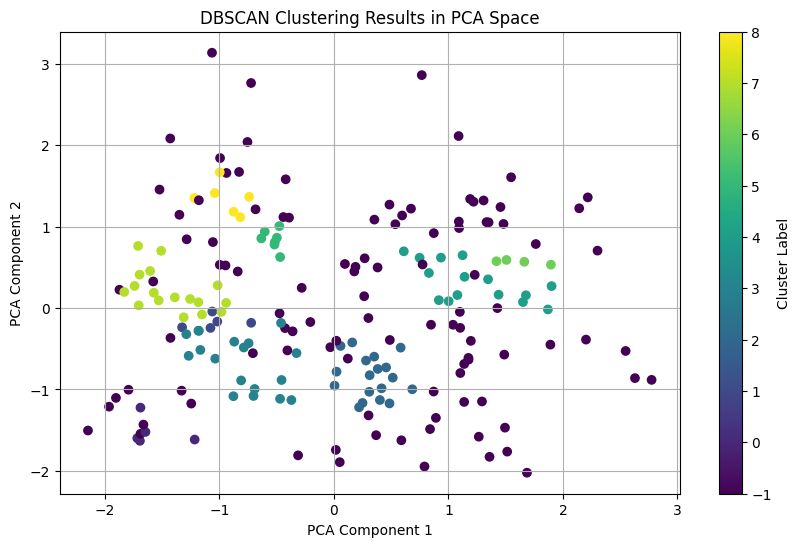

In [21]:
def plot_cluster_scatter(reduced_data, df):
    """Plots a scatter plot of PCA components with clusters highlighted."""
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df['Cluster'], cmap='viridis', marker='o')
    plt.title('DBSCAN Clustering Results in PCA Space')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(label='Cluster Label')
    plt.grid()
    plt.show()

# Run to visualize clusters in PCA space
plot_cluster_scatter(reduced_data, df)


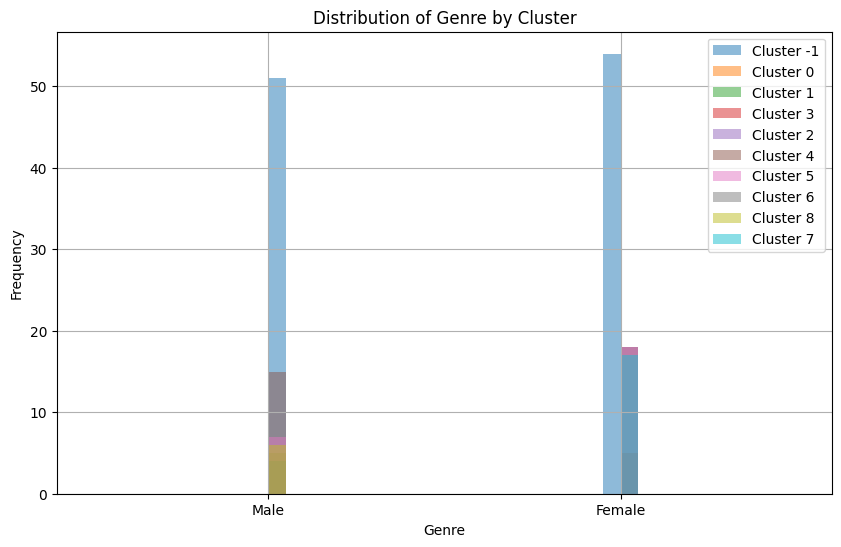

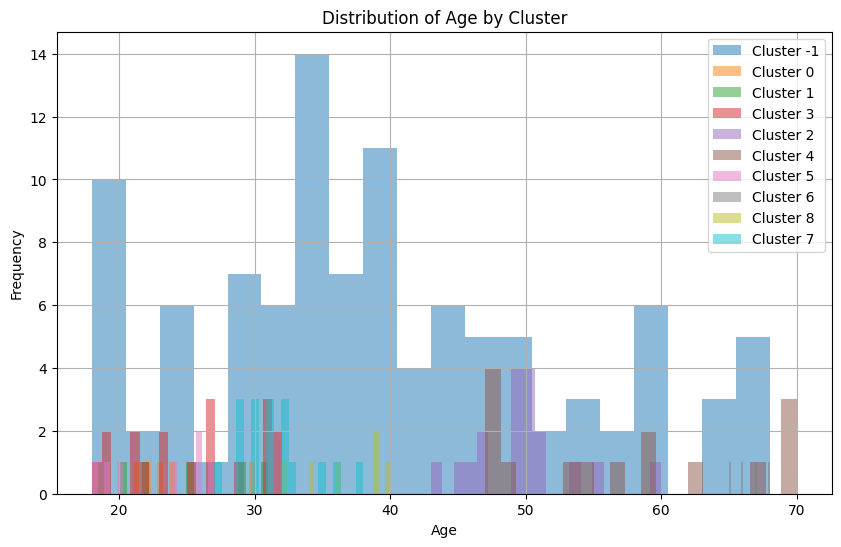

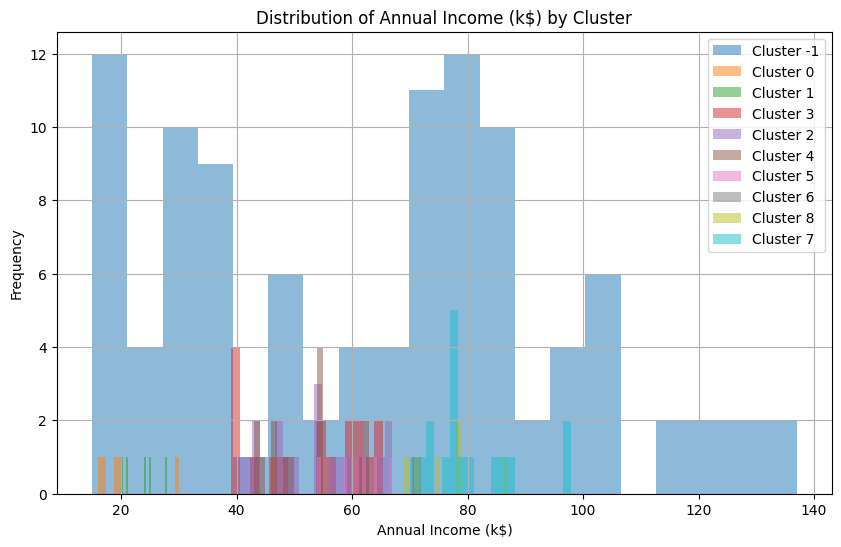

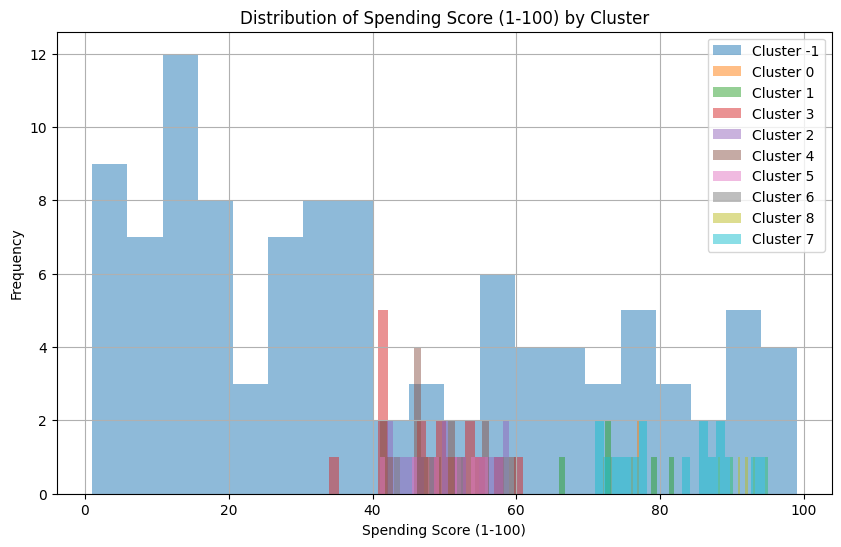

In [22]:
import matplotlib.pyplot as plt

def plot_feature_distributions(df):
    """Plots histograms for each feature segmented by cluster."""
    features = df.drop(columns=['CustomerID', 'Cluster'], errors='ignore')  # Exclude non-feature columns
    for column in features.columns:
        plt.figure(figsize=(10, 6))
        for cluster in df['Cluster'].unique():
            subset = df[df['Cluster'] == cluster]
            plt.hist(subset[column], alpha=0.5, bins=20, label=f'Cluster {cluster}')
        plt.title(f'Distribution of {column} by Cluster')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid()
        plt.show()

# Run to visualize feature distributions
plot_feature_distributions(df)
